# Initial conditions of test case

In this notebook we summarise the previous results and refocus on setting up the initial conditions.

See the details of the case below the imports and core function definitions in the cell below:

In [29]:

#import polyscope as ps


# ddg imports
import os, sys
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from hyperct import *
from ddgclib._sphere import *


def distance(a, b):
    return np.linalg.norm(a - b)

def circumcenter(vertices):
    A, B, C = vertices
    a = distance(B, C)
    b = distance(C, A)
    c = distance(A, B)

    if a == 0 or b == 0 or c == 0:
        raise ValueError("Invalid triangle: degenerate or duplicate vertices")

    # Calculate the circumradius
    s = (a + b + c) / 2
    area = np.sqrt(s * (s - a) * (s - b) * (s - c))
    circumradius = (a * b * c) / (4 * area)

    # Calculate the normalized barycentric coordinates
    alpha = (a * a * (b * b + c * c - a * a)) / (a * a + b * b + c * c)
    beta = (b * b * (c * c + a * a - b * b)) / (a * a + b * b + c * c)
    gamma = (c * c * (a * a + b * b - c * c)) / (a * a + b * b + c * c)

    circumcenter = (alpha * A + beta * B + gamma * C) / (alpha + beta + gamma)

    return circumcenter

# Example usage
#triangle_vertices = np.array([[1, 2, 0], [4, 0, 1], [0, 0, 5]], dtype=np.float64)
#print("Circumcenter:", circumcenter(triangle_vertices))


# Write a function that builds a dual cache called HC.Vd,
# each member of the `Vd` set should be connect only to primal
# vertices in HC.V

#dist = np.linalg.norm(v.x_a - v2.x_a)
#            if dist < cdist:
        
def compute_vd(HC, cdist =1e-10):
    """
    Computes the dual vertices of a primal vertex cache HC.V on
    each dim - 1 simplex.
    
    Currently only dim = 2 is supported
    
    cdist: float, tolerance for where a unique dual vertex can exist
    
    """
    # Construct dual cache
    HC.Vd = VertexCacheField() 
    
    # Construct dual neighbour sets
    for v in HC.V:
        v.vd = set()
            
    #hcv = copy.copy(HC.V)        
    for v1 in HC.V:
        for v2 in v1.nn:
            # Find all v2.nn also connected to v1:
            v1nn_u_v2nn = v1.nn.intersection(v2.nn)
            for v3 in v1nn_u_v2nn:
                # TODO: Re-implement cache:
                verts = np.zeros([3, 2])
                verts[0] = v1.x_a
                verts[1] = v2.x_a
                verts[2] = v3.x_a
                # Compute the circumcentre:
                cd = circumcenter(verts)
                # Note instead of below, could round off cd in general to say nearest 1e-12
                # Check for uniqueness first (new, expensive, could 
                # be improved by checking duals of neighbours only?):
                for vd_i in HC.Vd:
                    dist = np.linalg.norm(vd_i.x_a - cd)
                    if dist < cdist:
                        cd = vd_i.x_a
                        
                vd = HC.Vd[tuple(cd)]
                # Connect to all primal vertices
                for v in [v1, v2, v3]:
                    v.vd.add(vd)
                    vd.nn.add(v)
                    
    return HC  # self


# Find the Delaunay dual
def triang_dual(points, plot_delaunay=False):
    """
    Compute the Delaunay triangulation plus the dual points. Put into hyperct complex object.
    
    """
    tri = Delaunay(points)
    if plot_delaunay:  # Plot Delaunay complex
        import matplotlib.pyplot as plt
        plt.triplot(points[:,0], points[:,1], tri.simplices)
        plt.plot(points[:,0], points[:,1], 'o')
        plt.show()

    # Put Delaunay back into hyperct Complex object:
    HC = Complex(2)
    for s in tri.simplices:
        for v1i in s:
            for v2i in s:
                if v1i is v2i:
                    continue
                else:
                    v1 = tuple(points[v1i])
                    v2 = tuple(points[v2i])
                    HC.V[v1].connect(HC.V[v2])

    return HC, tri
    
    
# Plot duals
def plot_dual_mesh_2D(HC, tri):
    """
    Plot the dual mesh and show edge connectivity. Blue is the primary mesh. Orange is the dual mesh.
    """
    import matplotlib.pyplot as plt
    
    # Find the dual points
    dual_points = []
    for vd in HC.Vd:
        dual_points.append(vd.x_a)
    dual_points = np.array(dual_points)
    # Primal points 
    points = []
    for v in HC.V:
        points.append(v.x_a)
        
    points = np.array(points)
    
    for v in HC.V:
        # "Connect duals":
        for v2 in v.nn:
            v1vdv2vd = v.vd.intersection(v2.vd)  # Cardinality always 1 or 2?
            if len(v1vdv2vd) == 1:
                continue
            v1vdv2vd = list(v1vdv2vd)
            x = [v1vdv2vd[0].x[0], v1vdv2vd[1].x[0]]
            y = [v1vdv2vd[0].x[1], v1vdv2vd[1].x[1]]
            plt.plot(x, y, color='orange')

        for vd in v.vd:
            x = [v.x[0], vd.x[0]]
            y = [v.x[1], vd.x[1]]
            plt.plot(x, y, '--', color='tab:green')
    plt.triplot(points[:,0], points[:,1], tri.simplices, color='tab:blue')
    plt.plot(points[:,0], points[:,1],  'o', color='tab:blue')
    plt.plot(dual_points[:,0], dual_points[:,1], 'o', color='tab:orange')

    plt.show()

# Area computations
def d_area(vp1):
    """
    Compute the dual area of a vertex object vp1, which is the sum of the areas
    of the local dual triangles formed between vp1, its neighbouring vertices, 
    and their shared dual vertices.

    Parameters:
    -----------
    vp1 : object
        A vertex object containing the following attributes:
        - vp1.nn: a list of neighboring vertex objects
        - vp1.vd: a set of dual vertex objects
        - vp1.x_a: a numpy array representing the position of vp1

    Returns:
    --------
    darea : float
        The total dual area of the vertex object vp1
    """

    darea = 0  # Initialize total dual area to zero
    for vp2 in vp1.nn:  # Iterate over neighboring vertex objects
        # Find the shared dual vertices between vp1 and vp2
        vdnn = vp1.vd.intersection(vp2.vd)
        # Compute the midpoint between vp1 and vp2
        mp = (vp1.x_a + vp2.x_a) / 2
        # Compute the height of the dual triangle between vp1, vp2, and a dual vertex
        h = np.linalg.norm(mp - vp1.x_a)
        for vdi in vdnn:  # Iterate over shared dual vertices
            # Compute the base of the dual triangle between vp1, vp2, and vdi
            b = np.linalg.norm(vdi.x_a - mp)
            # Add the area of the dual triangle to the total dual area
            darea += 0.5 * b * h

    return darea



## This test case
# Test case traingulation
def incom_Poi(domain, refinements=2):
    """
    Compute the triangulate of a 2D incompressible Poiseuile flow
    """
    HC = Complex(2, domain)
    HC.triangulate()
    for i in range(refinements):
        HC.refine_all()

    points = []
    for v in HC.V:
        points.append(v.x_a)
    points = np.array(points)
    tri = Delaunay(points)
    return points

def u_x_analytical(y):
    """
    General pipe solution (NOT planar case)
    """
    return 4 * y * (1 - y)

def u_plane_analytical(x):
    y = x[1]
    return (G / 2 * mu) * y * (h - y)

def v_error(HC):
    MSE = 0
    for v in HC.V:
        u_anal = u_plane_analytical(v.x_a)
        MSE += (v.u[1]- u_anal)**2
    return MSE/HC.V.size()

## Initial conditions
# velocity
def v_IC(HC):
    # Assign velocity field to all points:
    for v in HC.V:
        v.u = np.array([u_ic(v.x_a), 0])
        
# velocity
def v_IC(HC, u_in):
    # Assign velocity field to all points:
    for v in HC.V:
        v.u = np.array([u_in, 0])

# mass 
def mass_IC(HC):
    # Set mass of each fluid particle:
    for v in HC.V:
        # Compute the dual area around a particle:
        area = d_area(v)
        V = area * 1  # m3, can be modified later
        # Set mass in kg
        v.m = rho * V
        
# Pressure IC (new)
def P_IC(HC):
    # Assign velocity field to all points:
    for v in HC.V:
        # NOTE: We assume that the vector here is in fact the 
        #       pressure _gradient_ potential, which is not 
        #       equivalent to the scalar pressure field.
        P_i = P_ic(v.x_a[0])
        v.P = np.array([P_i, P_i])  # Diagonal components # Pressure IC (new)
        
def P_IC(HC):
    # Assign velocity field to all points:
    for v in HC.V:
        # NOTE: We assume that the vector here is in fact the 
        #       pressure _gradient_ potential, which is not 
        #       equivalt to the scalar pressure field.
        P_i = P_ic(v.x_a[0])
        v.P = np.array([P_i, P_i])  # Diagonal components 
        
def P_ic(x):
    """
    Initial pressure condition (ASSUMED linear based on pressure drop)
    """
    return P_in - ((8 * np.pi * mu * x * Q) / (A**2))  # P_in - dP

# Initial condition:
def u_ic(x):
    y = x[1]
    return (G / 2 * mu) * y * (h - y)

# Solution
def u_plane_analytical(x):
    y = x[1]
    return (G / 2 * mu) * y * (h - y)

# Boundary conditions:
def u_bc(x):
    y = x[1]
    if y == 0:
        return 0.0
    elif y == h:
        return 0.0
    

def BC_bool(x):
    #if (x[0] == 0) or (x[0] == 1) or (x[1] == 0) or (x[1] == 1):
    #if (x[0]  == x_lb) or (x[0] == x_ub) or (x[1] == y_lb) or (x[1] == y_ub):
    if (x[1] == y_lb) or (x[1] == y_ub):
        return True
    else:
        return False
    
def in_domain(x):
    if (x[0] >= x_lb) and (x[0] <= x_ub) and (x[1] >= y_lb) and (x[1] <= y_ub):
        return True
    else:
        return False
    
# Test case 
def incomp_poiseuille_2d(refinements=2, R=1, u_in=0.1):
    # Solid boundaries of plate
    x_lb = 0
    x_ub = R  # For simplicity
    y_lb = 0
    y_ub = R  # Actual parallel plate dimension
    domain = [(x_lb, x_ub), (y_lb, y_ub)]
    points = incom_Poi(domain, refinements=refinements)
    HC, tri = triang_dual(points)
    #HC.vertex_face_mesh(field_conversions=True)              
    HC = compute_vd(HC)            
    # Optionally plot
    #plot_dual_mesh_2D(HC, tri)

    # For each vertex compute its local dual area:

    Areas = []
    for vp1 in HC.V:
        area = 0 
        area += d_area(vp1)
        Areas.append(area)

    # Set ICs:
    mass_IC(HC)  # mass IC
    v_IC(HC, u_in)  # Velocity IC
    P_IC(HC)  # Pressure field IC
    return HC, tri


# DDG
def dP(vp1):
    """
    Compute the integrated pressure differential for vertex v     
    """
    dP_i = 0  # Total integrated Laplacian for each vertex
    for vp2 in vp1.nn:  # Iterate over neighboring vertex objects
      #  l_ij = np.linalg.norm(vp2.x_a - vp1.x_a)  # Not used here?
        e_dual = 0  # Initialize total edge dual length to zero
        # Find the shared dual vertices between vp1 and vp2
        vdnn = vp1.vd.intersection(vp2.vd)
        # Compute the midpoint between vp1 and vp2
        mp = (vp1.x_a + vp2.x_a) / 2
        # Compute the height of the dual triangle between vp1, vp2, and a dual vertex
        #h = np.linalg.norm(mp - vp1.x_a)
        #print(f'vdnn = {vdnn})
        for vdi in vdnn:  # Iterate over shared dual vertices
            # Compute the base of the dual triangle between vp1, vp2, and vdi
            b = np.linalg.norm(vdi.x_a - mp)  # dihedral weight
            # Add the area of the dual triangle to the total dual area
            e_dual += b
            if e_dual <= 1e-12:  # TODO: Set tolerance
                e_dual = 0
               
        #w_ij = l_ij/e_dual  # Weight
        #if (w_ij is np.inf) or (e_dual == 0):
        
            continue
        # Compute the area flux for the pressure differential:
        Area = e_dual* 1  # m2, Chosen height was 1 for our 2D test case
        # Compute the dual
        dP_ij = Area * (vp2.P - vp1.P)
        dP_i += dP_ij
        
    return dP_i

def du(vp1):
    """
    Compute the Laplacian of the velocity field for vertex v
    
    TODO: Compare this with the     
    """
    du_i = 0  # Total integrated Laplacian for each vertex
    for vp2 in vp1.nn:  # Iterate over neighboring vertex objects
        l_ij = np.linalg.norm(vp2.x_a - vp1.x_a)
        e_dual = 0  # Initialize total edge dual length to zero
        # Find the shared dual vertices between vp1 and vp2
        vdnn = vp1.vd.intersection(vp2.vd)
        # Compute the midpoint between vp1 and vp2
        mp = (vp1.x_a + vp2.x_a) / 2
        # Compute the height of the dual triangle between vp1, vp2, and a dual vertex
        #h = np.linalg.norm(mp - vp1.x_a)
        #print(f'vdnn = {vdnn})
        for vdi in vdnn:  # Iterate over shared dual vertices
            # Compute the base of the dual triangle between vp1, vp2, and vdi
            b = np.linalg.norm(vdi.x_a - mp)  # dihedral weight
            # Add the area of the dual triangle to the total dual area
            e_dual += b
            if e_dual <= 1e-12:  # TODO: Set tolerance
                e_dual = 0
               
        w_ij = l_ij/e_dual  # Weight
       # print('.')
       # print(f'l_ij = {l_ij}')
       # print(f'e_dual, len(vdnn)  = {e_dual, len(vdnn)}')
       # print(f'w_ij = { w_ij}')
       # print(f'w_ij is np.inf = {w_ij is np.inf}')
       # print(f'w_ij == np.inf = {w_ij == np.inf}')
        if (w_ij is np.inf) or (e_dual == 0):
            continue
        # Compute the dual
        du_ij = w_ij * (vp2.u - vp1.u)
        du_i += du_ij
        
    return du_i

def dudt(v):
    # Equal to the acceleration at a vertex (RHS of equation)
    dudt = -dP(v) + mu * du(v)
    dudt = dudt/v.m  # normalize by mass
    return dudt

# Plots
def plot_field(p, u, xlim_lb=-1, xlim_ub=10, scale=1):
    """
    Plot the velocity fields using points `p` and
    associated velocities `u`.
    
    scale adjusts the scale of the shown arrow factors
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.colors import Normalize

    positions = p
    velocities = u

    # Separate the positions and velocities into x, y, u, and v arrays
    x, y = positions[:, 0], positions[:, 1]
    u, v = velocities[:, 0], velocities[:, 1]

    # Calculate the magnitude of the velocity vectors
    magnitude = np.sqrt(u**2 + v**2)  # Should be around 0.1
    
    # Set the normalization range for the colors of the arrows based on the actual magnitudes
    norm = Normalize(vmin=magnitude.min(), vmax=magnitude.max())

    plt.figure(figsize=(8, 8))
    quiver_plot = plt.quiver(x, y, u, v, magnitude, norm=norm, cmap='viridis', scale=scale)
    plt.scatter(x, y, s=0.1)
    #plt.colorbar(label='Magnitude of Velocity')
    cbar = plt.colorbar(quiver_plot)
    cbar.set_label('Magnitude of Velocity')
    plt.title('Quiver Plot from Position Points and Velocity Vectors')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.xlim(xlim_lb, xlim_ub)
    plt.ylim(0, 1)
    plt.show()

    

# Incompressible Poiseuille channel fluid flow

For this test case, we will closely follow the FENICS tutorial https://fenicsproject.org/pub/tutorial/html/._ftut1009.html in order to validate our method.


The incompressible Navier-Stokes equations are:
$$
\begin{aligned}
\rho\left(\frac{\partial u}{\partial t}+u \cdot \nabla u\right) & =\nabla \cdot \sigma(u, p)+f \\
\nabla \cdot u & =0 .
\end{aligned}
$$

for a Newtonian fluid we have 
$$
\sigma(u, p)=2 \mu \epsilon(u)-p I
$$
where $\epsilon(u)$ is the strain-rate tensor
$$
\epsilon(u)=\frac{1}{2}\left(\nabla u+(\nabla u)^T\right)
$$

In [31]:
v_error(HC)

6.809509409926391244e-17

In standard fluid-kinetics notation: 

$$
\Delta p=\frac{8 \mu L Q}{\pi R^4}=\frac{8 \pi \mu L Q}{A^2}
$$

where:
- $\Delta p$ is the pressure difference between the two ends,
- $L$ is the length of pipe,
- $\mu$ is the dynamic viscosity,
- $Q$ is the volumetric flow rate,
- $R$ is the pipe radius,
- $A$ is the cross sectional area of pipe.

In [32]:
import numpy as np
L = 1  # m
Q = 1  # m3 / s
R = 1  # m
A = 1  # m2  # = 2 pi * R**2 # for pipe
# Domain:
x_lb = 0
x_ub = R
y_lb = 0
y_ub = R
# Pressure drop for pipe
dP_anal = (8 * np.pi * mu * L * Q) / (A**2)
P_in = 101325 # Pa (kg⋅m−1⋅s−2), atmospheric pressure
#u_in = 1  # m⋅s−2, initial and inlet velocity   
u_in = 0.00001  # m⋅s−2, initial and inlet velocity

# Physical parameters
mu = 8.90 * 1e-4  # Pa·s
h = R  # m, plate seperation
Q = u_in * A  # m3/s, volumetric flowrate (CHECK)
G = (Q * 12 * mu) / (h**3)  # pressure gradient(?)
rho = 1000  # kg / m3
#G = dP/ L
Re = rho * Q * L / mu
Re

11.235955056179774

In [33]:
y = np.linspace(0, 1)
(G / 2 * mu) * y * (h - y)

array([0.00000000e+00, 9.50124115e-13, 1.86065973e-12, 2.73160683e-12,
       3.56296543e-12, 4.35473553e-12, 5.10691712e-12, 5.81951020e-12,
       6.49251479e-12, 7.12593086e-12, 7.71975843e-12, 8.27399750e-12,
       8.78864806e-12, 9.26371012e-12, 9.69918367e-12, 1.00950687e-11,
       1.04513653e-11, 1.07680733e-11, 1.10451928e-11, 1.12827239e-11,
       1.14806664e-11, 1.16390204e-11, 1.17577859e-11, 1.18369629e-11,
       1.18765514e-11, 1.18765514e-11, 1.18369629e-11, 1.17577859e-11,
       1.16390204e-11, 1.14806664e-11, 1.12827239e-11, 1.10451928e-11,
       1.07680733e-11, 1.04513653e-11, 1.00950687e-11, 9.69918367e-12,
       9.26371012e-12, 8.78864806e-12, 8.27399750e-12, 7.71975843e-12,
       7.12593086e-12, 6.49251479e-12, 5.81951020e-12, 5.10691712e-12,
       4.35473553e-12, 3.56296543e-12, 2.73160683e-12, 1.86065973e-12,
       9.50124115e-13, 0.00000000e+00])

### Plane Poiseuille flow
Plane Poiseuille flow is flow created between two infinitely long parallel plates, separated by a distance $h$ with a constant pressure gradient $G=-\frac{\mathrm{d} p}{\mathrm{dx}}$ is applied in the direction of flow. The flow is essentially unidirectional because of infinite length. The Navier-Stokes equations reduce to
$$
\frac{\mathrm{d}^2 u}{\mathrm{~d} y^2}=-\frac{G}{\mu}
$$
with no-slip condition on both walls
$$
u(0)=0, \quad u(h)=0
$$
Therefore, the velocity distribution and the volume flow rate per unit length are
$$
u(y)=\frac{G}{2 \mu} y(h-y), \quad Q=\frac{G h^3}{12 \mu}
$$

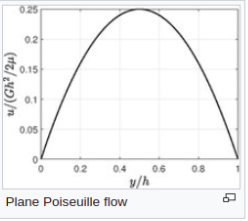


In [34]:
# Physical parameters
mu = 8.90 * 1e-4  # Pa·s
h = R  # m, plate seperation
Q = u_in * A  # m3/s, volumetric flowrate (CHECK)
G = (Q * 12 * mu) / (h**3)  # pressure gradient(?)
rho = 1000  # kg / m3
#G = dP/ L
Re = rho * Q * L / mu
Re

11.235955056179774

# Integrators


$$
\boldsymbol{F}_{\boldsymbol{i}}=\boldsymbol{m}_{\boldsymbol{i}} \boldsymbol{a}_{\boldsymbol{i}}=\boldsymbol{F}_{\boldsymbol{g}, \boldsymbol{i}}+\int_{\Omega} \nabla \cdot \boldsymbol{\sigma} d V+\boldsymbol{F}_{\boldsymbol{s}, \boldsymbol{i}}
$$
The remaining term $\int_{\Omega} \nabla \cdot \sigma d V$ is the focus of this project. Since it is possible to find near-exact solutions for $\boldsymbol{F}_{g, i}$ and $\boldsymbol{F}_{s, i}$ in any continuous space (subject only to floating-point errors), then a mesh-independent near-exact three-phase method is possible when a near-exact solution for $\int_{\Omega} \nabla \cdot \sigma d V$ can be obtained (additionally a Symplectic integrator for time is used for Equation 1 ensuring energy conservation is preserved for the integration as much as possible). In the more familiar Navier-Stokes equation $\left.\mid \rho\left(\frac{\partial \mathbf{v}}{\partial t}+(\mathbf{v} \cdot \nabla) \mathbf{v}\right)=\rho \mathbf{f}-\nabla p+\mu\left(\nabla^2 \mathbf{v}\right)\right]$, for compressible flows we have the correspondence:
$$
\int_{\Omega} \nabla \cdot \boldsymbol{\sigma} d V=-\int_{\Omega} \nabla p d V+\int_{\Omega} \mu\left(\nabla^2 \mathbf{v}\right) d V
$$
The term $\int_{\Omega} \mu\left(\nabla^2 \mathbf{v}\right) d V$ is simply an integrated vector Laplacian (which is a vector-value integral with vectors of dimension 3). Mathematically this is identical to the $\int_S \gamma H N d A$ term [] except we have velocity vectors in $\mathbb{R}^3$ integrated over a domain in $\mathbb{R}^3$ as opposed to the $\mathbb{R}^3$ position



## Derivation in 2D incompressible flow
### Pressure gradient

We start with the simplified 2D Cauchy tensor, in this test case we have, in the $xx$ normal direction the integrated quantity:

$$\int  \nabla \cdot \sigma |_{xx}= \int \frac{\partial \sigma_{xx}}{\partial x} $$



Where $\sigma_{xx}$ is simply the vector pressure differential in the $x$ direction. Therefore, the exact (FTC) solution to this equation between two discreet spatial points $x^{N=i}$ and $x^{N=i+1}$ is simply

$$ \int^{x^{N=i+1}}_{x^{N=i}} \frac{\partial \sigma_{xx}}{\partial x} = P^{1+1} - P^{i} $$

Therefore the force acting on a fluid particle $i$ is simply 

$$ F_i = \frac{\sum^N P^{1+1} - P^{i}}{A_i m_i} $$ for each edge $e_{ij} \in N$

### Deviatoric incompressible stress
The divergence of the deviatoric stress is given by:
$$\nabla \cdot \boldsymbol \tau = 2 \mu \nabla \cdot \boldsymbol \varepsilon = \mu \nabla \cdot \left( \nabla\mathbf{u} + \nabla\mathbf{u} ^\mathrm{T} \right) = \mu \, \nabla^2 \mathbf{u}
$$
since $\nabla \cdot \mathbf{u} = 0$ for an incompressible fluid.



As a first attempt, we will assume the Laplacian can be computed directly on the velocity field:

### Idea: Initiate new row when a certain amount of required mass has moved through.
### Idea 2: Initiate larger boundary with constant fluid particles

### Idea 3: Pressure difference between boundary and first bulk particle zero


Need about 10 times the width for the length of the tube.

# Evolve the symplectic time integrator

Use a first-order symplectic time integrator
$$
\begin{aligned}
&   v_{i+1}=v_i + a\left(x_i\right) \Delta t \\
& x_{i+1}=x_i + v_{i+1}\Delta t 
\end{aligned}
$$

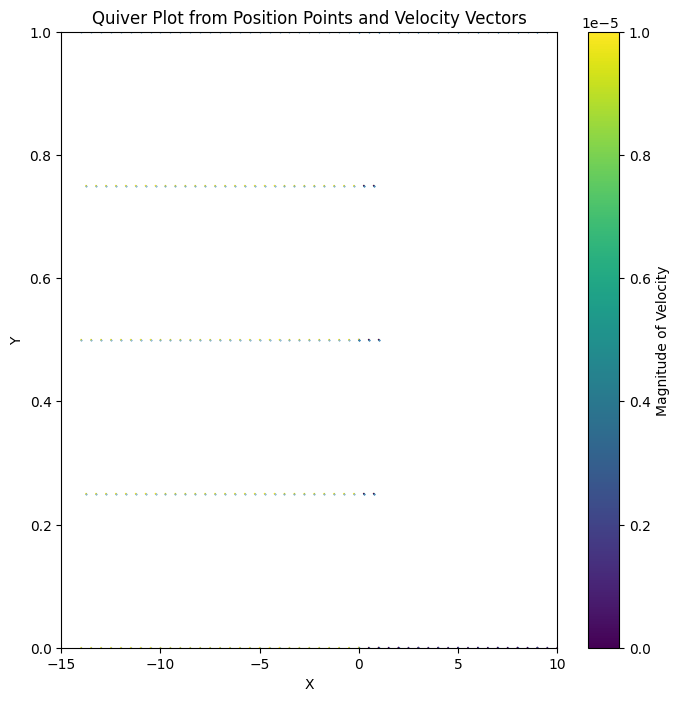

Error = 5.701097860096156e-23


In [35]:
def full_incomp_poiseuille_2d(refinements = 1, x_lb = 0, x_ub = R, y_lb = 0, y_ub = R):
    domain = [(x_lb, x_ub), (y_lb, y_ub)]


    # Draw the initial test case points
    points = incom_Poi(domain, refinements=refinements)
    HC, tri = triang_dual(points)
    HC = compute_vd(HC)

    # Set ICs:
    mass_IC(HC)  # mass IC
    v_IC(HC, u_in)  # Velocity IC
    P_IC(HC)  # Pressure field IC

    # Plot IC velocity field
    V = []  # List of all vertices including outside the domain
    p = []  # POINTS for field, not pressure
    u = []  # Velocity for field
    m = []  # mass field (for setting inflow conditions)
    for v in HC.V:
        V.append(v.x_a)
        p.append(v.x_a)
        u.append(v.u)
        m.append(v.m)

    ## BC
    # Set outflow BC fluid parcels:
    BV = []  # List of current BC fluid particles
    for bv in HC.V:  # 
        if (bv.x_a[1] == y_lb) or (bv.x_a[1] == y_ub):
            BV.append(bv.x_a)

    #V = []
    BV = np.array(BV)
    for n in range(1, 10):
        shift = np.zeros(BV.shape)
        shift[:, 0] = n * x_ub
        Vn = BV + shift
        for va in Vn:
            V.append(va)

    # Add non-domain particles
    for va in V:
        #V.append(va)
        p.append(va)
        u.append([0.0, 0])

    # Set inflow fluid parcels:
    #  strategy add a "inflow complex simply to store data"
    Vi = []  # inlet vertices
    Ui = []  # inlet velocities
    HCi = Complex(2)
    for n in range(1, 15):
        shift = np.zeros(points.shape)
        shift[:, 0] = -n * x_ub
        Vn = points + shift
        Vi_na = []
        Ui_na = []
        for va in Vn:
            Vi.append(va)
            Ui.append([u_in, 0])
            Vi_na.append(va)
            Ui_na.append([u_in, 0])

        Vi_na = np.array(Vi_na, dtype='float64')
        Ui_na = np.array(Ui_na, dtype='float64')

        # Define mass, velocity and pressure?
        for i in range(points.shape[0]):
            v = HCi.V[tuple(Vi_na[i])]
            v.u = Ui_na[i]
            v.P = P_in 
            v.m = m[i]

    for v in HCi.V:
        V.append(v.x_a)
        p.append(v.x_a)
        u.append(v.u)
        m.append(v.m)
    
    return HC, HCi, p, u

    
HC, HCi, p, u = full_incomp_poiseuille_2d()
        
p = np.array(p, dtype='float64')
u = np.array(u, dtype='float64')
plot_field(p, u, xlim_lb=-15, xlim_ub=10, scale=0.03)
print(f'Error = {v_error(HC)}')

In [36]:
from scipy.spatial import Delaunay
tri = scipy.spatial.Delaunay(points)
tri.points - points  # seems to preserve order!

array([[ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 6.61744490e-24, -1.59919820e-17],
       [ 3.91396984e-17, -5.57008866e-18],
       [ 3.23092247e-17,  5.31259065e-17],
       [-8.75493254e-18, -1.04083409e-17],
       [-7.31836466e-18,  2.55329612e-17],
       [-4.88433079e-17, -1.69677640e-17],
       [-3.08108235e-20,  3.44776291e-17]], dtype=float128)

In [37]:
def add_fluid_to_complex(HC, v):
    """
    Add the fluid particle from another complex with all its physical properties
    """
    vn = HC.V[v.x]
    vn.u = v.u
    vn.P = v.P
    vn.m = v.m
    return HC

def vector_complex(HC):
    """
    Return vectorised version of complex 
    """
    points = []
    M = []
    U = []
    P = []
    for v in HC.V:
        points.append(v.x_a)
        M.append(v.m)
        U.append(v.u)
        P.append(v.P)
        
    points, M, U, P = np.array(points), np.array(M), np.array(U), np.array(P)
    return points, M, U, P

In [38]:
HC, tri = incomp_poiseuille_2d(refinements=3, R=1)
points, M, U, P = vector_complex(HC)
points, M, U, P

(array([[1.    , 0.125 ],
        [0.9375, 0.0625],
        [1.    , 0.    ],
        [0.875 , 0.    ],
        [0.9375, 0.9375],
        [1.    , 0.875 ],
        [1.    , 1.    ],
        [0.875 , 1.    ],
        [0.9375, 0.1875],
        [1.    , 0.25  ],
        [1.    , 0.375 ],
        [0.9375, 0.3125],
        [0.9375, 0.8125],
        [1.    , 0.75  ],
        [0.9375, 0.6875],
        [1.    , 0.625 ],
        [0.9375, 0.4375],
        [1.    , 0.5   ],
        [0.9375, 0.5625],
        [0.125 , 0.    ],
        [0.0625, 0.0625],
        [0.    , 0.    ],
        [0.    , 0.125 ],
        [0.8125, 0.0625],
        [0.75  , 0.    ],
        [0.6875, 0.0625],
        [0.625 , 0.    ],
        [0.1875, 0.0625],
        [0.25  , 0.    ],
        [0.375 , 0.    ],
        [0.3125, 0.0625],
        [0.5625, 0.0625],
        [0.5   , 0.    ],
        [0.4375, 0.0625],
        [0.0625, 0.9375],
        [0.125 , 1.    ],
        [0.    , 1.    ],
        [0.    , 0.875 ],
        [0.8

In [50]:
#HC, tri = incomp_poiseuille_2d(refinements=3, R=1)
HC, HCi, p, u = full_incomp_poiseuille_2d(refinements = 1, x_lb=x_lb, x_ub=x_ub, y_lb=y_lb, y_ub=y_ub)
tspan = np.linspace(0, 10, 2000)
dt = tspan[1]

for t in tspan:       
    # Set new pressure 
    P_IC(HC)  # TODO: Validate

    HCVc = copy.copy(HC.V)
    for v in HCVc:
        # Wall boundary condition:
        if BC_bool(v.x_a):
            v.u = np.zeros(2)  # TODO: READD
            continue

        # Update velocity i + 1
        dadt = dudt(v)  # = (-dP(v) + mu * du(v)) / m_i
        u_new = v.u + dadt * dt   
        v.u = u_new  # v = dxdt
        # Update position i + 1
        x_new = v.x_a + v.u * dt
        HC.V.move(v, tuple(x_new))
    

    

/tmp/ipykernel_143520/3114493151.py:436: RuntimeWarning: divide by zero encountered in longdouble_scalars
  w_ij = l_ij/e_dual  # Weight


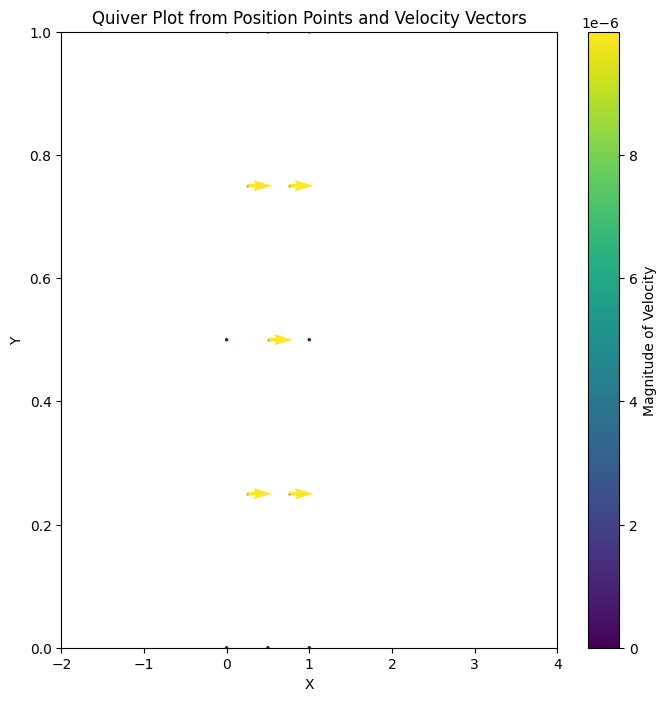

Error = 6.687597579320952e-23


In [67]:
# Plot IC velocity field
p = []
u = []
for v in HC.V:
    p.append(v.x_a)
    u.append(v.u)
    
p = np.array(p, dtype='float64')
u = np.array(u, dtype='float64')
plot_field(p, u, xlim_lb=-2, xlim_ub=4, scale=2e-4)
print(f'Error = {v_error(HC)}')

In [68]:
#HC, tri = incomp_poiseuille_2d(refinements=3, R=1)
HC, HCi, p, u = full_incomp_poiseuille_2d(refinements = 2, x_lb=x_lb, x_ub=x_ub, y_lb=y_lb, y_ub=y_ub)
tspan = np.linspace(0, 10, 2000)
dt = tspan[1]

for t in tspan:       
    # Set new pressure 
    P_IC(HC)  # TODO: Validate

    HCVc = copy.copy(HC.V)
    for v in HCVc:
        # Wall boundary condition:
        if BC_bool(v.x_a):
            v.u = np.zeros(2)  # TODO: READD
            continue

        # Update velocity i + 1
        dadt = dudt(v)  # = (-dP(v) + mu * du(v)) / m_i
        u_new = v.u + dadt * dt   
        v.u = u_new  # v = dxdt
        # Update position i + 1
        x_new = v.x_a + v.u * dt
        HC.V.move(v, tuple(x_new))
    

    

/tmp/ipykernel_143520/3114493151.py:436: RuntimeWarning: divide by zero encountered in longdouble_scalars
  w_ij = l_ij/e_dual  # Weight


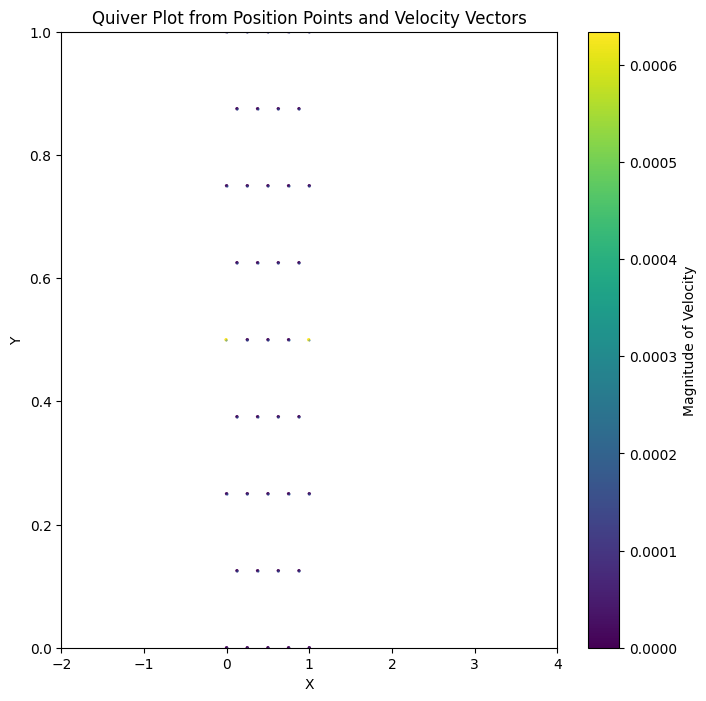

Error = 2.5319834279726857e-18


In [73]:
# Plot IC velocity field
p = []
u = []
for v in HC.V:
    p.append(v.x_a)
    u.append(v.u)
    
p = np.array(p, dtype='float64')
u = np.array(u, dtype='float64')
plot_field(p, u, xlim_lb=-2, xlim_ub=4, scale=1e-1)
print(f'Error = {v_error(HC)}')

In [74]:
#HC, tri = incomp_poiseuille_2d(refinements=3, R=1)
HC, HCi, p, u = full_incomp_poiseuille_2d(refinements = 3, x_lb=x_lb, x_ub=x_ub, y_lb=y_lb, y_ub=y_ub)
tspan = np.linspace(0, 10, 2000)
dt = tspan[1]

for t in tspan:       
    # Set new pressure 
    P_IC(HC)  # TODO: Validate

    HCVc = copy.copy(HC.V)
    for v in HCVc:
        # Wall boundary condition:
        if BC_bool(v.x_a):
            v.u = np.zeros(2)  # TODO: READD
            continue

        # Update velocity i + 1
        dadt = dudt(v)  # = (-dP(v) + mu * du(v)) / m_i
        u_new = v.u + dadt * dt   
        v.u = u_new  # v = dxdt
        # Update position i + 1
        x_new = v.x_a + v.u * dt
        HC.V.move(v, tuple(x_new))
    

    

/tmp/ipykernel_143520/3114493151.py:436: RuntimeWarning: divide by zero encountered in longdouble_scalars
  w_ij = l_ij/e_dual  # Weight


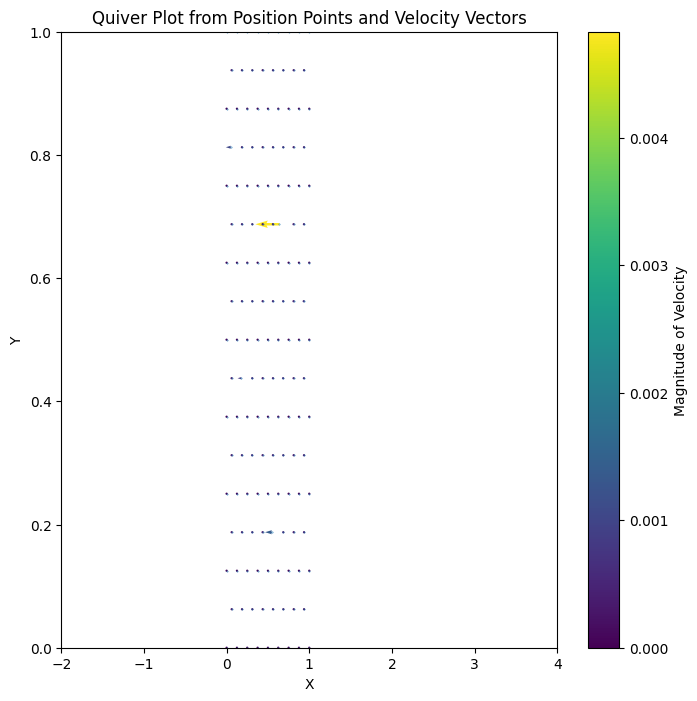

Error = 6.93239412643903e-14


In [78]:
# Plot IC velocity field
p = []
u = []
for v in HC.V:
    p.append(v.x_a)
    u.append(v.u)
    
p = np.array(p, dtype='float64')
u = np.array(u, dtype='float64')
plot_field(p, u, xlim_lb=-2, xlim_ub=4, scale=1e-1)
print(f'Error = {v_error(HC)}')

In [79]:
for v in HC.V:
    print(v.u)

[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[-2.39654451e-07 -2.11983996e-10]
[-9.68664451e-05 -5.87770480e-08]
[-1.35139606e-04 -9.79336861e-08]
[-2.48084075e-07 -2.20517430e-10]
[-1.15365714e-04 -7.00484152e-08]
[-2.65950447e-06 -1.63719531e-09]
[-1.14963149e-05 -4.66979043e-09]
[-1.62422193e-04 -9.91296339e-08]
[-1.5665258e-04 -1.0926511e-07]
[-2.73047201e-06 -1.70057440e-09]
[-2.22107573e-04 -1.46268420e-07]
[-1.17136138e-05 -4.84256045e-09]
[-2.75146452e-04 -1.68926519e-07]
[-1.95804054e-05 -6.52592657e-09]
[-4.45927556e-04 -2.81434353e-07]
[-1.39877352e-04 -6.63499040e-08]
[-2.41742421e-07  1.81007556e-10]
[-1.06700734e-04 -6.21576488e-08]
[-1.33198111e-04 -7.20940676e-08]
[-1.39052309e-04 -6.62005859e-08]
[-1.45874091e-04 -6.98725113e-08]
[-1.88296284e-04 -9.36539572e-08]
[-1.54124190e-04 -7.56224442e-08]
[-2.50707563e-04 -1.57256633e-07]
[-2.98408675e-07  1.52465764e-10]
[-1.4647

In [80]:
#HC, tri = incomp_poiseuille_2d(refinements=3, R=1)
HC, HCi, p, u = full_incomp_poiseuille_2d(refinements = 1, x_lb=x_lb, x_ub=x_ub, y_lb=y_lb, y_ub=y_ub)
tspan = np.linspace(0, 10, 2000)
dt = tspan[1]

for t in tspan:       
    # Set new pressure 
    P_IC(HC)  # TODO: Validate

    HCVc = copy.copy(HC.V)
    for v in HCVc:
        # Wall boundary condition:
        if BC_bool(v.x_a):
            v.u = np.zeros(2)  # TODO: READD
            continue

        # Update velocity i + 1
        dadt = dudt(v)  # = (-dP(v) + mu * du(v)) / m_i
        print(f'dadt = {dadt}')
        u_new = v.u + dadt * dt   
        v.u = u_new  # v = dxdt
        # Update position i + 1
        x_new = v.x_a + v.u * dt
        HC.V.move(v, tuple(x_new))
    

    

/tmp/ipykernel_143520/3114493151.py:436: RuntimeWarning: divide by zero encountered in longdouble_scalars
  w_ij = l_ij/e_dual  # Weight


dadt = [-6.32666571e-10 -6.32666571e-10]
dadt = [1.76601685e-17 1.76601685e-17]
dadt = [3.02342591e-17 3.02342084e-17]
dadt = [-7.11999249e-11  7.51477375e-17]
dadt = [6.32666485e-10 6.32666490e-10]
dadt = [-1.21894242e-10  1.60139837e-16]
dadt = [-4.70719556e-17 -4.01943568e-17]
dadt = [-5.69315263e-03  1.16916848e-09]
dadt = [-3.70524868e-10 -4.09020797e-17]
dadt = [-4.76509965e-10 -3.22892754e-17]
dadt = [-2.31486913e-10  5.63838398e-17]
dadt = [-5.69315138e-03 -1.16916720e-09]
dadt = [-4.72247803e-10 -3.74493490e-17]
dadt = [-1.02306963e-16 -4.01943530e-17]
dadt = [ 1.24067652e-02 -2.43450084e-09]
dadt = [ 8.99337248e-11 -3.66965130e-16]
dadt = [ 1.03684242e-10 -4.31354205e-16]
dadt = [-3.93910303e-10 -2.24247870e-16]
dadt = [1.24067856e-02 2.43450153e-09]
dadt = [ 1.13650732e-10 -1.71529541e-16]
dadt = [-2.50041968e-17  4.01943441e-17]
dadt = [-7.06840497e-03  9.07149941e-10]
dadt = [-2.15348412e-10 -2.80072472e-16]
dadt = [-1.80335936e-10 -2.88705455e-16]
dadt = [1.42779381e-10 3

dadt = [-2.14258765e-10 -7.22316434e-15]
dadt = [4.20183653e-16 3.46333665e-16]
dadt = [-2.14249028e-10 -7.23792790e-15]
dadt = [-3.71211992e-15 -4.02902708e-17]
dadt = [1.68121150e-16 2.96763745e-16]
dadt = [-2.14224312e-10 -1.53486966e-14]
dadt = [-2.14225068e-10 -1.53732302e-14]
dadt = [-2.14253279e-10 -7.31081924e-15]
dadt = [4.77207404e-16 4.03356061e-16]
dadt = [-2.14243705e-10 -7.32566022e-15]
dadt = [-3.74264194e-15 -4.02918806e-17]
dadt = [1.91273636e-16 3.19914970e-16]
dadt = [-2.14219530e-10 -1.55223861e-14]
dadt = [-2.14220241e-10 -1.55470534e-14]
dadt = [-2.14247906e-10 -7.41862839e-15]
dadt = [5.00361020e-16 4.26508342e-16]
dadt = [-2.14238491e-10 -7.43360383e-15]
dadt = [-3.69277450e-15  4.00952234e-17]
dadt = [1.20285440e-16 2.48925533e-16]
dadt = [-2.14214726e-10 -1.55955904e-14]
dadt = [-2.14215394e-10 -1.56200988e-14]
dadt = [-2.14242523e-10 -7.42565972e-15]
dadt = [4.29373967e-16 3.55519976e-16]
dadt = [-2.14233263e-10 -7.44047530e-15]
dadt = [-3.80368382e-15 -4.029

dadt = [-2.13927123e-10 -3.13966421e-14]
dadt = [-2.13923748e-10 -1.50825131e-14]
dadt = [4.77833732e-16 4.03899609e-16]
dadt = [-2.13921400e-10 -1.50974274e-14]
dadt = [-7.47401299e-15  3.97881534e-17]
dadt = [1.11167903e-16 2.39728359e-16]
dadt = [-2.13926418e-10 -3.14452330e-14]
dadt = [-2.1392594e-10 -3.1469762e-14]
dadt = [-2.13922437e-10 -1.50896197e-14]
dadt = [4.20284538e-16 3.46350085e-16]
dadt = [-2.13920107e-10 -1.51044549e-14]
dadt = [-7.58487864e-15 -4.06039026e-17]
dadt = [1.68191257e-16 2.96751144e-16]
dadt = [-2.13925324e-10 -3.15988202e-14]
dadt = [-2.13924846e-10 -3.16233864e-14]
dadt = [-2.13921217e-10 -1.51772309e-14]
dadt = [4.77306742e-16 4.03371964e-16]
dadt = [-2.13918905e-10 -1.51921033e-14]
dadt = [-7.61535537e-15 -4.06072304e-17]
dadt = [1.91342518e-16 3.19901977e-16]
dadt = [-2.13924261e-10 -3.17725047e-14]
dadt = [-2.13923783e-10 -3.17971363e-14]
dadt = [-2.13920027e-10 -1.52849675e-14]
dadt = [5.00459831e-16 4.26524728e-16]
dadt = [-2.13917734e-10 -1.52999

dadt = [-2.13833578e-10 -4.83422391e-14]
dadt = [-2.13833211e-10 -4.83667969e-14]
dadt = [-2.13817019e-10 -2.32729875e-14]
dadt = [4.21630820e-16 3.47667424e-16]
dadt = [-2.13815989e-10 -2.32878519e-14]
dadt = [-1.16067138e-14 -4.11610741e-17]
dadt = [1.68738378e-16 2.97266687e-16]
dadt = [-2.13833197e-10 -4.85159206e-14]
dadt = [-2.13832831e-10 -4.85405214e-14]
dadt = [-2.13816561e-10 -2.33806999e-14]
dadt = [4.77880005e-16 4.03916462e-16]
dadt = [-2.13815536e-10 -2.33956074e-14]
dadt = [-1.15567873e-14  3.92225428e-17]
dadt = [1.11187336e-16 2.39715567e-16]
dadt = [-2.13832718e-10 -4.85891163e-14]
dadt = [-2.13832353e-10 -4.86136659e-14]
dadt = [-2.13816005e-10 -2.33878325e-14]
dadt = [4.20331103e-16 3.46367412e-16]
dadt = [-2.13814986e-10 -2.34026887e-14]
dadt = [-1.16676382e-14 -4.11713256e-17]
dadt = [1.68210740e-16 2.96738584e-16]
dadt = [-2.13832322e-10 -4.87427006e-14]
dadt = [-2.13831958e-10 -4.87672743e-14]
dadt = [-2.13815533e-10 -2.34754288e-14]
dadt = [4.77352582e-16 4.033

dadt = [-2.13766884e-10 -3.18959312e-14]
dadt = [-1.57295793e-14  3.83931921e-17]
dadt = [1.20377677e-16 2.48886362e-16]
dadt = [-2.13793374e-10 -6.61331830e-14]
dadt = [-2.13793115e-10 -6.61577535e-14]
dadt = [-2.13767154e-10 -3.18881611e-14]
dadt = [4.21679067e-16 3.47699898e-16]
dadt = [-2.13766579e-10 -3.19030384e-14]
dadt = [-1.58404233e-14 -4.20025317e-17]
dadt = [1.71945693e-16 3.00454268e-16]
dadt = [-2.13793233e-10 -6.63068615e-14]
dadt = [-2.13792975e-10 -6.63314634e-14]
dadt = [-2.13766948e-10 -3.19958610e-14]
dadt = [4.77919032e-16 4.03939777e-16]
dadt = [-2.13766375e-10 -3.20107698e-14]
dadt = [-1.57904898e-14  3.83792046e-17]
dadt = [1.12492744e-16 2.41001211e-16]
dadt = [-2.13792992e-10 -6.63800541e-14]
dadt = [-2.13792735e-10 -6.64046185e-14]
dadt = [-2.13766643e-10 -3.20030061e-14]
dadt = [4.20367099e-16 3.46387756e-16]
dadt = [-2.13766072e-10 -3.20178773e-14]
dadt = [-1.59013337e-14 -4.20165450e-17]
dadt = [1.68744576e-16 2.97252934e-16]
dadt = [-2.13792853e-10 -6.655

dadt = [-2.13739729e-10 -4.07478014e-14]
dadt = [-2.01952239e-14 -4.31408951e-17]
dadt = [1.68217589e-16 2.96711387e-16]
dadt = [-2.13775121e-10 -8.45709676e-14]
dadt = [-2.13774933e-10 -8.45955489e-14]
dadt = [-2.13739982e-10 -4.08205100e-14]
dadt = [4.77413440e-16 4.03423817e-16]
dadt = [-2.13739616e-10 -4.08353990e-14]
dadt = [-2.02256753e-14 -4.31498227e-17]
dadt = [1.91368386e-16 3.19862322e-16]
dadt = [-2.13775087e-10 -8.47446434e-14]
dadt = [-2.13774900e-10 -8.47692493e-14]
dadt = [-2.13739889e-10 -4.09282016e-14]
dadt = [5.00567840e-16 4.26578156e-16]
dadt = [-2.13739524e-10 -4.09431152e-14]
dadt = [-2.01757379e-14  3.72299642e-17]
dadt = [1.20378371e-16 2.48872313e-16]
dadt = [-2.13774954e-10 -8.48178334e-14]
dadt = [-2.13774767e-10 -8.48424099e-14]
dadt = [-2.13739695e-10 -4.09353535e-14]
dadt = [4.29581570e-16 3.55591824e-16]
dadt = [-2.13739331e-10 -4.09502377e-14]
dadt = [-2.02865780e-14 -4.31677352e-17]
dadt = [1.71946382e-16 3.00440020e-16]
dadt = [-2.13774921e-10 -8.499

dadt = [-2.13768610e-10 -1.00123687e-13]
dadt = [-2.13726467e-10 -4.83616504e-14]
dadt = [5.00804309e-16 4.26808127e-16]
dadt = [-2.13726197e-10 -4.83765621e-14]
dadt = [-2.38297802e-14  3.60581027e-17]
dadt = [1.20463246e-16 2.48946797e-16]
dadt = [-2.13768673e-10 -1.00172272e-13]
dadt = [-2.13768525e-10 -1.00196850e-13]
dadt = [-2.13726323e-10 -4.83688055e-14]
dadt = [4.29691093e-16 3.55694862e-16]
dadt = [-2.13726054e-10 -4.83836924e-14]
dadt = [-2.39406184e-14 -4.43412201e-17]
dadt = [1.71980375e-16 3.00464075e-16]
dadt = [-2.13768689e-10 -1.00345945e-13]
dadt = [-2.13768541e-10 -1.00370545e-13]
dadt = [-2.13726281e-10 -4.84764922e-14]
dadt = [4.81202058e-16 4.07205779e-16]
dadt = [-2.13726012e-10 -4.84913998e-14]
dadt = [-2.38906791e-14  3.60369182e-17]
dadt = [1.12506247e-16 2.40989965e-16]
dadt = [-2.13768604e-10 -1.00419133e-13]
dadt = [-2.13768457e-10 -1.00443708e-13]
dadt = [-2.13726138e-10 -4.84836474e-14]
dadt = [4.21731168e-16 3.47734839e-16]
dadt = [-2.13725870e-10 -4.849

dadt = [-2.13766991e-10 -1.14632305e-13]
dadt = [-2.13766870e-10 -1.14656885e-13]
dadt = [-2.13718102e-10 -5.53700206e-14]
dadt = [4.77454538e-16 4.03453251e-16]
dadt = [-2.13717891e-10 -5.53849098e-14]
dadt = [-2.73813343e-14 -4.56242590e-17]
dadt = [1.91364063e-16 3.19839026e-16]
dadt = [-2.13767035e-10 -1.14805977e-13]
dadt = [-2.13766914e-10 -1.14830575e-13]
dadt = [-2.13718089e-10 -5.54777036e-14]
dadt = [5.00609814e-16 4.26608485e-16]
dadt = [-2.13717878e-10 -5.54926110e-14]
dadt = [-2.73313938e-14  3.47523510e-17]
dadt = [1.20373855e-16 2.48848974e-16]
dadt = [-2.13766979e-10 -1.14879162e-13]
dadt = [-2.13766858e-10 -1.14903739e-13]
dadt = [-2.13717975e-10 -5.54848608e-14]
dadt = [4.29624409e-16 3.55623037e-16]
dadt = [-2.13717765e-10 -5.54997465e-14]
dadt = [-2.74422308e-14 -4.56485265e-17]
dadt = [1.71942697e-16 3.00417841e-16]
dadt = [-2.13767024e-10 -1.15052834e-13]
dadt = [-2.13766903e-10 -1.15077429e-13]
dadt = [-2.13717963e-10 -5.55925438e-14]
dadt = [4.81186490e-16 4.071

dadt = [4.78006906e-16 4.04001300e-16]
dadt = [-2.13712597e-10 -6.22912842e-14]
dadt = [-3.06806553e-14  3.33360423e-17]
dadt = [1.11188982e-16 2.39656418e-16]
dadt = [-2.13767966e-10 -1.28938534e-13]
dadt = [-2.13767865e-10 -1.28963107e-13]
dadt = [-2.13712674e-10 -6.22835415e-14]
dadt = [4.20456646e-16 3.46451003e-16]
dadt = [-2.13712503e-10 -6.22984235e-14]
dadt = [-3.07914915e-14 -4.70663212e-17]
dadt = [1.68212226e-16 2.96679692e-16]
dadt = [-2.13768010e-10 -1.29092107e-13]
dadt = [-2.13767909e-10 -1.29116688e-13]
dadt = [-2.13712661e-10 -6.23711172e-14]
dadt = [4.77474049e-16 4.03468371e-16]
dadt = [-2.13712490e-10 -6.23860083e-14]
dadt = [-3.08219389e-14 -4.70799549e-17]
dadt = [1.91361390e-16 3.19828575e-16]
dadt = [-2.13768074e-10 -1.29265776e-13]
dadt = [-2.13767973e-10 -1.29290374e-13]
dadt = [-2.13712668e-10 -6.24787972e-14]
dadt = [5.00629178e-16 4.26623463e-16]
dadt = [-2.13712498e-10 -6.24937043e-14]
dadt = [-3.07719977e-14  3.32951269e-17]
dadt = [1.20370404e-16 2.48837

dadt = [4.81221686e-16 4.07212379e-16]
dadt = [-2.13709268e-10 -6.88601823e-14]
dadt = [-3.39080579e-14  3.18164499e-17]
dadt = [1.12482613e-16 2.40943071e-16]
dadt = [-2.13770637e-10 -1.42503987e-13]
dadt = [-2.13770551e-10 -1.42528561e-13]
dadt = [-2.13709331e-10 -6.88524395e-14]
dadt = [4.21772706e-16 3.47763366e-16]
dadt = [-2.13709188e-10 -6.88673243e-14]
dadt = [-3.40188936e-14 -4.85873480e-17]
dadt = [1.68735496e-16 2.97195959e-16]
dadt = [-2.13770715e-10 -1.42677654e-13]
dadt = [-2.13770629e-10 -1.42702244e-13]
dadt = [-2.13709352e-10 -6.89601170e-14]
dadt = [4.78018424e-16 4.04009052e-16]
dadt = [-2.13709209e-10 -6.89750163e-14]
dadt = [-3.39689518e-14  3.17863172e-17]
dadt = [1.11182963e-16 2.39643138e-16]
dadt = [-2.13770692e-10 -1.42750836e-13]
dadt = [-2.13770606e-10 -1.42775408e-13]
dadt = [-2.13709272e-10 -6.89672765e-14]
dadt = [4.20472008e-16 3.46462602e-16]
dadt = [-2.13709130e-10 -6.89821584e-14]
dadt = [-3.40797875e-14 -4.86175065e-17]
dadt = [1.68207549e-16 2.96667

dadt = [-2.13707147e-10 -7.58533148e-14]
dadt = [4.21805425e-16 3.47792476e-16]
dadt = [-2.13707027e-10 -7.58682014e-14]
dadt = [-3.74593781e-14 -5.03760620e-17]
dadt = [1.68737569e-16 2.97190971e-16]
dadt = [-2.13774920e-10 -1.57137004e-13]
dadt = [-2.13774846e-10 -1.57161593e-13]
dadt = [-2.13707179e-10 -7.59609899e-14]
dadt = [4.78042089e-16 4.04029110e-16]
dadt = [-2.13707059e-10 -7.59758898e-14]
dadt = [-3.74094360e-14  2.99960752e-17]
dadt = [1.11181397e-16 2.39634487e-16]
dadt = [-2.13774908e-10 -1.57210184e-13]
dadt = [-2.13774834e-10 -1.57234757e-13]
dadt = [-2.1370711e-10 -7.5968150e-14]
dadt = [4.20492603e-16 3.46479593e-16]
dadt = [-2.13706990e-10 -7.59830341e-14]
dadt = [-3.75202713e-14 -5.04092774e-17]
dadt = [1.68204740e-16 2.96657672e-16]
dadt = [-2.13774976e-10 -1.57363752e-13]
dadt = [-2.13774902e-10 -1.57388333e-13]
dadt = [-2.13707122e-10 -7.60557221e-14]
dadt = [4.77509099e-16 4.03496059e-16]
dadt = [-2.13707002e-10 -7.60706136e-14]
dadt = [-3.75507179e-14 -5.04258

dadt = [-2.13780367e-10 -1.72267959e-13]
dadt = [-2.13706054e-10 -8.32789869e-14]
dadt = [5.00682917e-16 4.26666446e-16]
dadt = [-2.13705952e-10 -8.32938892e-14]
dadt = [-4.10021221e-14  2.79423888e-17]
dadt = [1.20358347e-16 2.48804437e-16]
dadt = [-2.13780426e-10 -1.72316545e-13]
dadt = [-2.13780363e-10 -1.72341122e-13]
dadt = [-2.13705994e-10 -8.32861473e-14]
dadt = [4.29699188e-16 3.55682687e-16]
dadt = [-2.13705892e-10 -8.33010352e-14]
dadt = [-4.11129572e-14 -5.24645614e-17]
dadt = [1.71928070e-16 3.00374195e-16]
dadt = [-2.13780523e-10 -1.72490209e-13]
dadt = [-2.13780460e-10 -1.72514797e-13]
dadt = [-2.13706034e-10 -8.33938202e-14]
dadt = [4.81258892e-16 4.07242362e-16]
dadt = [-2.13705933e-10 -8.34087202e-14]
dadt = [-4.10630149e-14  2.79059535e-17]
dadt = [1.12473913e-16 2.40919764e-16]
dadt = [-2.13780519e-10 -1.72563386e-13]
dadt = [-2.13780456e-10 -1.72587960e-13]
dadt = [-2.13705974e-10 -8.34009807e-14]
dadt = [4.21810564e-16 3.47794005e-16]
dadt = [-2.13705873e-10 -8.341

dadt = [-2.13705652e-10 -9.04165080e-14]
dadt = [-4.46142883e-14 -5.46487220e-17]
dadt = [1.68722889e-16 2.97162050e-16]
dadt = [-2.13786704e-10 -1.87175816e-13]
dadt = [-2.13786649e-10 -1.87200397e-13]
dadt = [-2.13705767e-10 -9.04891898e-14]
dadt = [4.78072581e-16 4.04052854e-16]
dadt = [-2.13705679e-10 -9.05040831e-14]
dadt = [-4.46447346e-14 -5.46684952e-17]
dadt = [1.11170049e-16 2.39609065e-16]
dadt = [-2.13786726e-10 -1.87269088e-13]
dadt = [-2.13786671e-10 -1.87293661e-13]
dadt = [-2.13705733e-10 -9.05164525e-14]
dadt = [4.20527384e-16 3.46507629e-16]
dadt = [-2.13705646e-10 -9.05313374e-14]
dadt = [-4.46751810e-14 -5.46882771e-17]
dadt = [1.68195545e-16 2.96634730e-16]
dadt = [-2.13786809e-10 -1.87422652e-13]
dadt = [-2.13786754e-10 -1.87447231e-13]
dadt = [-2.13705760e-10 -9.06040213e-14]
dadt = [4.77544323e-16 4.03524543e-16]
dadt = [-2.13705672e-10 -9.06189124e-14]
dadt = [-4.47056273e-14 -5.47080761e-17]
dadt = [1.91344988e-16 3.19784212e-16]
dadt = [-2.13786911e-10 -1.875

dadt = [1.11166546e-16 2.39600373e-16]
dadt = [-2.13792283e-10 -1.99292366e-13]
dadt = [-2.13792234e-10 -1.99316939e-13]
dadt = [-2.13706030e-10 -9.63356375e-14]
dadt = [4.20542039e-16 3.46519791e-16]
dadt = [-2.13705951e-10 -9.63505227e-14]
dadt = [-4.75371358e-14 -5.66088582e-17]
dadt = [1.68191919e-16 2.96625696e-16]
dadt = [-2.13792370e-10 -1.99445929e-13]
dadt = [-2.13792321e-10 -1.99470507e-13]
dadt = [-2.13706061e-10 -9.64232052e-14]
dadt = [4.77558596e-16 4.03536322e-16]
dadt = [-2.13705982e-10 -9.64380962e-14]
dadt = [-4.75675821e-14 -5.66299280e-17]
dadt = [1.91341117e-16 3.19774844e-16]
dadt = [-2.13792477e-10 -1.99619588e-13]
dadt = [-2.13792428e-10 -1.99644177e-13]
dadt = [-2.13706112e-10 -9.65308746e-14]
dadt = [5.00716376e-16 4.26694076e-16]
dadt = [-2.13706033e-10 -9.65457760e-14]
dadt = [-4.75176397e-14  2.37377200e-17]
dadt = [1.20349677e-16 2.48783355e-16]
dadt = [-2.13792483e-10 -1.99692762e-13]
dadt = [-2.13792435e-10 -1.99717338e-13]
dadt = [-2.13706062e-10 -9.653

dadt = [-5.1221147e-14 -5.9256923e-17]
dadt = [1.91550339e-16 3.19977334e-16]
dadt = [-2.13800089e-10 -2.14972062e-13]
dadt = [-2.13800047e-10 -2.14996651e-13]
dadt = [-2.13707017e-10 -1.03963355e-13]
dadt = [5.00949658e-16 4.26924299e-16]
dadt = [-2.13706949e-10 -1.03978256e-13]
dadt = [-5.11712046e-14  2.11091029e-17]
dadt = [1.20431546e-16 2.48858493e-16]
dadt = [-2.13800100e-10 -2.15045234e-13]
dadt = [-2.13800057e-10 -2.15069810e-13]
dadt = [-2.13706972e-10 -1.03970515e-13]
dadt = [4.29839669e-16 3.55814284e-16]
dadt = [-2.13706904e-10 -1.03985405e-13]
dadt = [-5.12820398e-14 -5.93023652e-17]
dadt = [1.71950197e-16 3.00377096e-16]
dadt = [-2.13800211e-10 -2.15218891e-13]
dadt = [-2.13800169e-10 -2.15243477e-13]
dadt = [-2.13707028e-10 -1.04078183e-13]
dadt = [4.81345819e-16 4.07320409e-16]
dadt = [-2.13706959e-10 -1.04093082e-13]
dadt = [-5.12320975e-14  2.10636349e-17]
dadt = [1.12474995e-16 2.40901846e-16]
dadt = [-2.13800222e-10 -2.15292062e-13]
dadt = [-2.13800180e-10 -2.15316

dadt = [-2.1380961e-10 -2.3300636e-13]
dadt = [-2.13809573e-10 -2.33030947e-13]
dadt = [-2.13708669e-10 -1.12691836e-13]
dadt = [5.00971355e-16 4.26942543e-16]
dadt = [-2.13708609e-10 -1.12706736e-13]
dadt = [-5.54641623e-14  1.77718214e-17]
dadt = [1.20425212e-16 2.48844169e-16]
dadt = [-2.13809625e-10 -2.33079529e-13]
dadt = [-2.13809588e-10 -2.33104105e-13]
dadt = [-2.13708628e-10 -1.12698996e-13]
dadt = [4.29861876e-16 3.55833039e-16]
dadt = [-2.13708568e-10 -1.12713886e-13]
dadt = [-5.55749977e-14 -6.26415535e-17]
dadt = [1.71944418e-16 3.00363548e-16]
dadt = [-2.13809740e-10 -2.33253184e-13]
dadt = [-2.13809703e-10 -2.33277769e-13]
dadt = [-2.13708687e-10 -1.12806662e-13]
dadt = [4.81367272e-16 4.07338411e-16]
dadt = [-2.13708628e-10 -1.12821560e-13]
dadt = [-5.55250556e-14  1.77225415e-17]
dadt = [1.12469177e-16 2.40888349e-16]
dadt = [-2.13809755e-10 -2.33326352e-13]
dadt = [-2.13809718e-10 -2.33350927e-13]
dadt = [-2.13708646e-10 -1.12813822e-13]
dadt = [4.21899227e-16 3.47870

dadt = [-5.88023477e-14 -6.53287722e-17]
dadt = [1.91325724e-16 3.19738995e-16]
dadt = [-2.13817244e-10 -2.46817053e-13]
dadt = [-2.13817211e-10 -2.46841638e-13]
dadt = [-2.13710280e-10 -1.19374798e-13]
dadt = [5.00773095e-16 4.26741723e-16]
dadt = [-2.13710227e-10 -1.19389697e-13]
dadt = [-5.87524058e-14  1.50338897e-17]
dadt = [1.20333864e-16 2.48747178e-16]
dadt = [-2.13817261e-10 -2.46890219e-13]
dadt = [-2.13817228e-10 -2.46914794e-13]
dadt = [-2.13710242e-10 -1.19381958e-13]
dadt = [4.29791553e-16 3.55760156e-16]
dadt = [-2.13710188e-10 -1.19396847e-13]
dadt = [-5.88632414e-14 -6.53809453e-17]
dadt = [1.71904370e-16 3.00317415e-16]
dadt = [-2.13817358e-10 -2.47043775e-13]
dadt = [-2.13817326e-10 -2.47068355e-13]
dadt = [-2.13710284e-10 -1.19469521e-13]
dadt = [4.81348182e-16 4.07316763e-16]
dadt = [-2.13710230e-10 -1.19484415e-13]
dadt = [-5.88936882e-14 -6.54070462e-17]
dadt = [1.12449753e-16 2.40862662e-16]
dadt = [-2.13817396e-10 -2.47137039e-13]
dadt = [-2.13817363e-10 -2.471

---
# Older code below:
---
---
---

In [39]:
#HC, tri = incomp_poiseuille_2d(refinements=3, R=1)
HC, HCi, p, u = full_incomp_poiseuille_2d(refinements = 1, x_lb=x_lb, x_ub=x_ub, y_lb=y_lb, y_ub=y_ub)
tspan = np.linspace(0, 10, 2000)
dt = tspan[1]

for t in tspan:
    # Inlet BC:
    HCiVc = copy.copy(HCi.V)
    for v in HCiVc:
        if BC_bool(v.x_a):
            v.u = np.zeros(2)  # TODO: READD
            continue
        # Move the inlet fluid #TODO: Should come firt? 
        # (no velocity change!)
        x_new = v.x_a + v.u * dt
        HCi.V.move(v, tuple(x_new))
        if in_domain(v.x_a):
            HCi.V.remove(v)
            add_fluid_to_complex(HC, v)
            # Add to the list of points in domain
        
    # Remove points not currently in domain:
    HCVc = copy.copy(HC.V)
    for v in HCVc:
        if not in_domain(v.x_a):
            HC.V.remove(v)
        
    # Now rebuild the triangulation and add the points:
    # Retriangulate ONLY the points in the domain:
    HCVc = copy.copy(HC.V)
    points, M, U, P = vector_complex(HC)
    HC, tri = triang_dual(points)
    HC = compute_vd(HC)
    if 0:  # Doesn't appear to work:
        for i, p in enumerate(tri.points):  # We know this is ordered, not certain about HC.V
            v = HC.V[tuple(p)]
            v.m = M[i]
            v.u = U[i]
            v.P = P[i]  # NOTE: Gets reset below anyway, can be deleted
    for i, v in enumerate(HC.V):
        v.m = M[i]
        v.u = U[i]
        v.P = P[i]  # NOTE: Gets reset below anyway, can be deleted
    # Set new pressure 
    P_IC(HC)  # TODO: Validate

    HCVc = copy.copy(HC.V)
    for v in HCVc:
        # Wall boundary condition:
        if BC_bool(v.x_a):
            v.u = np.zeros(2)  # TODO: READD
            continue

        # Update velocity i + 1
        dadt = dudt(v)  # = (-dP(v) + mu * du(v)) / m_i
        u_new = v.u + dadt * dt   
        v.u = u_new  # v = dxdt
        # Update position i + 1
        x_new = v.x_a + v.u * dt
        HC.V.move(v, tuple(x_new))
    

    

/tmp/ipykernel_143520/3813530892.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  points, M, U, P = np.array(points), np.array(M), np.array(U), np.array(P)
/tmp/ipykernel_143520/3114493151.py:436: RuntimeWarning: divide by zero encountered in longdouble_scalars
  w_ij = l_ij/e_dual  # Weight


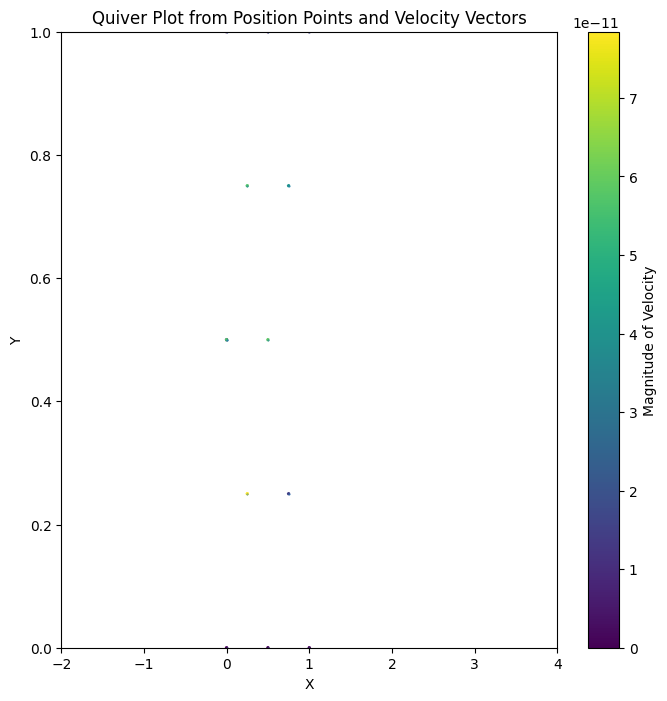

Error = 4.070211845589114e-22


In [46]:
# Plot IC velocity field
p = []
u = []
for v in HC.V:
    p.append(v.x_a)
    u.append(v.u)
    
p = np.array(p, dtype='float64')
u = np.array(u, dtype='float64')
plot_field(p, u, xlim_lb=-2, xlim_ub=4, scale=1e-1)
print(f'Error = {v_error(HC)}')

In [41]:
HCVc = copy.copy(HC.V)
for v in HCVc:
    print(v.u)
    

[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[1.04502245e-11 1.04502245e-11]
[2.87882472e-11 2.87882472e-11]
[4.15498898e-11 4.15498898e-11]
[3.44539776e-12 3.44539776e-12]
[3.9903163e-11 3.9903163e-11]
[5.54528212e-11 5.54528212e-11]
[4.0392585e-11 4.0392585e-11]


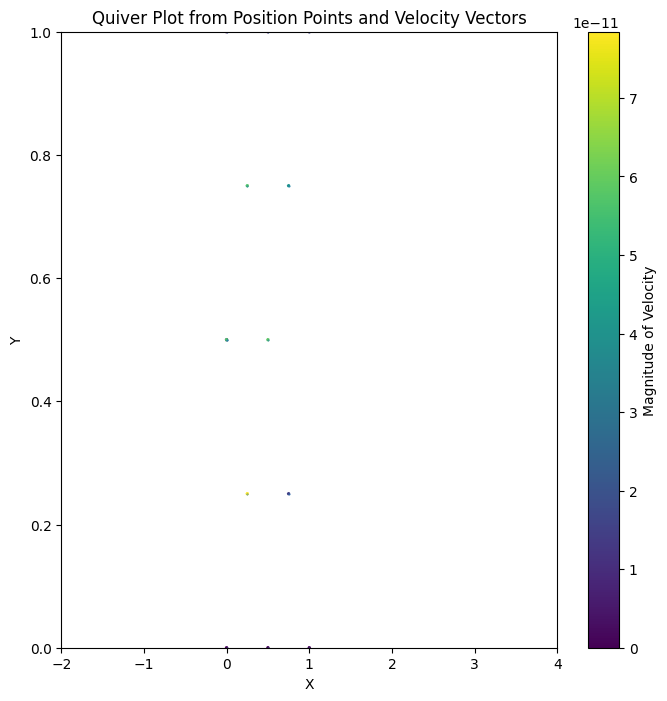

Error = 4.070211845589114e-22


In [42]:
# Plot IC velocity field
p = []
u = []
for v in HC.V:
    p.append(v.x_a)
    u.append(v.u)
    
p = np.array(p, dtype='float64')
u = np.array(u, dtype='float64')
plot_field(p, u, xlim_lb=-2, xlim_ub=4, scale=1e-3)
print(f'Error = {v_error(HC)}')